# Credit: https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention
**Check above links for more exciting tutorial**

# Neural Machine Translation with Attention

This notebook trains a sequence to sequence (seq2seq) model for Hindi to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, we will be able to input a Hindi sentence, such as **"तुम कहाँ गए थे?"**, and return the English translation: **"where did you go?"**



In [1]:
#https://stackoverflow.com/questions/7075082/what-is-future-in-python-used-for-and-how-when-to-use-it-and-how-it-works
#With __future__ module's inclusion, you can slowly be accustomed to incompatible changes or to such ones introducing new keywords.
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

#https://docs.python.org/2/library/unicodedata.html
import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

TensorFlow 2.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
hin_eng=pd.read_fwf('hin_eng.txt')

# Text_Preprocessing

In [0]:
#text preprocessing
def preprocess_sentence(w):
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [14]:
print(preprocess_sentence(data.English.loc[0]))

<start> Help ! <end>


In [0]:
lines = io.open('/content/drive/My Drive/Colab Notebooks/hin_eng.txt', encoding='UTF-8').read().strip().replace('\n',' start ').split('\t')
eng=[]
hin=[]
for n in range(2,len(lines),2):
    a=lines[n]
    i=(a.find('start'))
    eng.append(a[i+6:])

for n in range(3,len(lines),2):
    hin.append(lines[n])

In [0]:
eng=eng[:2783]
hin=hin[:2783]
english=[]
hindi=[]
for i in eng:
    sen=preprocess_sentence(i)
    english.append(sen)

for i in hin:
    sen=preprocess_sentence(i)
    hindi.append(sen)

In [0]:
data=pd.DataFrame(list(zip(english, hindi)),columns =['English', 'Hindi'])

In [86]:
data.tail()

,English,Hindi
2778,<start> Mother Teresa used the prize money for...,"<start> मदर टेरेसा को जो इनाम में पैसे मिले , ..."
2779,"<start> If you go to that supermarket , you ca...",<start> उस सूपरमार्केट में तुम लगभग कोई भी रोज...
2780,<start> The passengers who were injured in the...,<start> जिन यात्रियों को दुर्घटना मे चोट आई थी...
2781,<start> Democracy is the worst form of governm...,"<start> लोकतंत्र सरकार का सबसे घिनौना रूप है ,..."
2782,<start> If my boy had not been killed in the t...,<start> अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं ...


# maximum length function of tensor

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

# Tokenizeing function

**filters: a string where each element is a character that will be
    filtered from the texts. The default is all punctuation, plus
    tabs and line breaks, minus the `'` character.**
    https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [0]:
def tokenize(lang):
  #below code vectorizes text and returns a sequence of integer 
  #you can read more about this here 
  #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  #here fit and text to sequence works same as we have seen in scikit learn
  lang_tokenizer.fit_on_texts(lang)
  
  #transforms into sequence of information
  #https://rdrr.io/cran/keras/man/texts_to_sequences.html
  tensor = lang_tokenizer.texts_to_sequences(lang)
  
  #this will do post padding of tensor
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
english_tensor,english_tokenizer=tokenize(english)
hindi_tensor,hindi_tokenizer=tokenize(hindi)

In [26]:
english_tensor

array([[   1,   92,   63, ...,    0,    0,    0],
       [   1,  551,    3, ...,    0,    0,    0],
       [   1,  551,    3, ...,    0,    0,    0],
       ...,
       [   1,    4, 2380, ...,    0,    0,    0],
       [   1, 2382,    9, ...,    0,    0,    0],
       [   1,   77,   14, ...,  105,    3,    2]], dtype=int32)

# Dividing dataset into train and validation

In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(english_tensor, hindi_tensor, test_size=0.2)

# Show length
#print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

### Create a tf.data dataset
**from_tensor_slices creates a dataset with a separate element for each row of the input tensor:**\
**please follow this two link to read more**
https://stackoverflow.com/questions/49579684/difference-between-dataset-from-tensors-and-dataset-from-tensor-slices \
https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428

In [0]:
#length of input tensor train
BUFFER_SIZE = len(input_tensor_train)
#batch size
BATCH_SIZE = 64
#steps taken in each epochs
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
#total embedding dimensions of tensor
embedding_dim = 256
units = 1024
#vocabulary size of input and target
vocab_inp_size = len(english_tokenizer.word_index)+1
vocab_tar_size = len(hindi_tokenizer.word_index)+1

#tf.data.Dataset.from_tensor.slices
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

**next returns next items from the iterator**\
**please follow this link to read more** https://www.programiz.com/python-programming/methods/built-in/next

In [30]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 22]), TensorShape([64, 24]))

In [0]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(hindi_tensor), max_length(english_tensor)

**https://ai.googleblog.com/2016/09/a-neural-network-for-machine.html**

# Encoder
> An encoder neural network reads and encodes a source sen-tence into a fixed-length vector

In [0]:
class Encoder(tf.keras.Model):
    
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    #The super() builtin returns a proxy object that allows you to refer parent class by 'super'.
    #https://www.programiz.com/python-programming/methods/built-in/super
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [32]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
#calling the initialize_hidden_state function
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 22, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


**tf.expand_dims inserts a dimension of 1 in input shape**\
https://www.tensorflow.org/api_docs/python/tf/expand_dims

In [0]:
#https://arxiv.org/abs/1409.0473
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [34]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


# Decoder
> A decoder outputs a translation from the encoded vector

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [36]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 3004)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([hindi_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [42]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7475
Epoch 1 Loss 2.2678
Time taken for 1 epoch 35.30059313774109 sec

Epoch 2 Batch 0 Loss 1.8323
Epoch 2 Loss 1.8948
Time taken for 1 epoch 5.707517623901367 sec

Epoch 3 Batch 0 Loss 1.7517
Epoch 3 Loss 1.7549
Time taken for 1 epoch 4.209693431854248 sec

Epoch 4 Batch 0 Loss 1.6116
Epoch 4 Loss 1.6650
Time taken for 1 epoch 5.0230278968811035 sec

Epoch 5 Batch 0 Loss 1.4901
Epoch 5 Loss 1.5780
Time taken for 1 epoch 4.226661682128906 sec

Epoch 6 Batch 0 Loss 1.4658
Epoch 6 Loss 1.4882
Time taken for 1 epoch 5.567097187042236 sec

Epoch 7 Batch 0 Loss 1.5111
Epoch 7 Loss 1.4081
Time taken for 1 epoch 4.212133407592773 sec

Epoch 8 Batch 0 Loss 1.2734
Epoch 8 Loss 1.3362
Time taken for 1 epoch 5.075854539871216 sec

Epoch 9 Batch 0 Loss 1.1989
Epoch 9 Loss 1.2702
Time taken for 1 epoch 4.2619593143463135 sec

Epoch 10 Batch 0 Loss 1.1804
Epoch 10 Loss 1.1967
Time taken for 1 epoch 5.544325828552246 sec

Epoch 11 Batch 0 Loss 1.0169
Epoch 11 Loss 1.1278
Time t

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [english_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([hindi_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += hindi_tokenizer.index_word[predicted_id] + ' '

        if hindi_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
%matplotlib inline
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [46]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> jump <end>
Predicted translation: कूदो . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2370 missing from current font.
  font.set_text(s, 

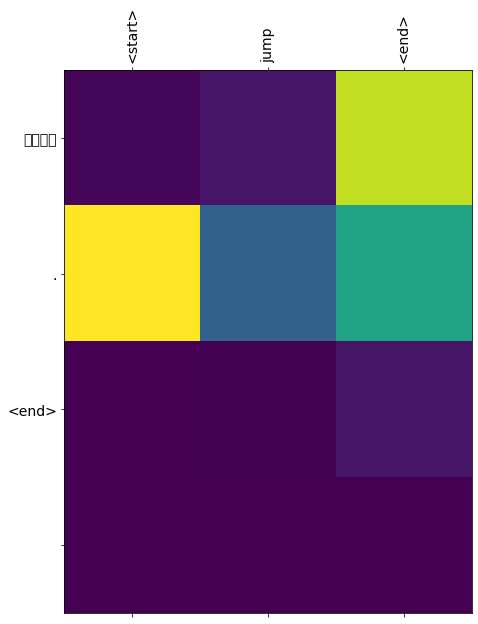

In [84]:
translate('jump')